<a href="https://colab.research.google.com/github/camoragaq/C-uoh/blob/main/Clase_funciones_exec_fork_pipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ejemplos de uso de las funciones exec(), fork(), pipe()

1. Programa en C que ilustra el uso de las funciones de llamadas al sistema de fork() y exec() para procesos de creación.

In [4]:
%%writefile eje1.c

#include <stdio.h>
#include <sys/types.h>
#include <unistd.h>
#include <stdlib.h>
#include <errno.h>
#include <sys/wait.h>

int main(){
pid_t pid;
int ret = 1;
int status;
pid = fork();

if (pid == -1){

	// pid == -1 significa que retorno error la función
	printf("Error con fork\n");
	exit(EXIT_FAILURE);
}
else if (pid == 0){//proceso hijo

	printf("proceso hijo con pid = %u\n",getpid());
	printf("proceso padre con pid = %u\n",getppid());

	// ocupamos este char puntero arreglo para guardar la instrucción a ejecutar con la función exec()
	char * argv_list[] = {"ls","-lart","/home",NULL};

	// llamamos a la función execv(), esta solo retornará en caso de error, el valor -1
	execv("ls",argv_list);
	exit(0);
}
else{//entramos en el proceso padre

	printf("Padre del proceso padre con pid = %u\n",getppid());
	printf("proceso padre con pid = %u\n",getpid());


    //el proceso padre llama a la función wait para enterrar los procesos hijos antes de cerrarse
		if (waitpid(pid, &status, 0) > 0) {//si wait retorna un valor mayor a 0 habra que especificar que es lo que ocurrió
			
			if (WIFEXITED(status) && !WEXITSTATUS(status))//espera el retorno de proceso hijo y función exec()
			printf("programa se ejecuta exitosamente!\n");
			
			else if (WIFEXITED(status) && WEXITSTATUS(status)) {
				if (WEXITSTATUS(status) == 127) {//significa que falla la función execv()

					// execv failed
					printf("execv falló\n");
				}
				else
					printf("programa termina,"
					" pero retorna un valor diferente\n");			
			}
			else
			printf("programa no termina de manera normal\n");		
		}
		else {
		// waitpid() failed
		printf("waitpid() falló\n");
		}
	exit(0);
}
return 0;
}


Overwriting eje1.c


In [5]:
!gcc eje1.c -o eje1

In [6]:
!./eje1

Padre del proceso padre con pid = 73
proceso hijo con pid = 138
proceso padre con pid = 137
proceso padre con pid = 137
programa se ejecuta exitosamente!


Se entienden las diferencias entre fork() y exec(), que se resumen en la siguiente tabla: 

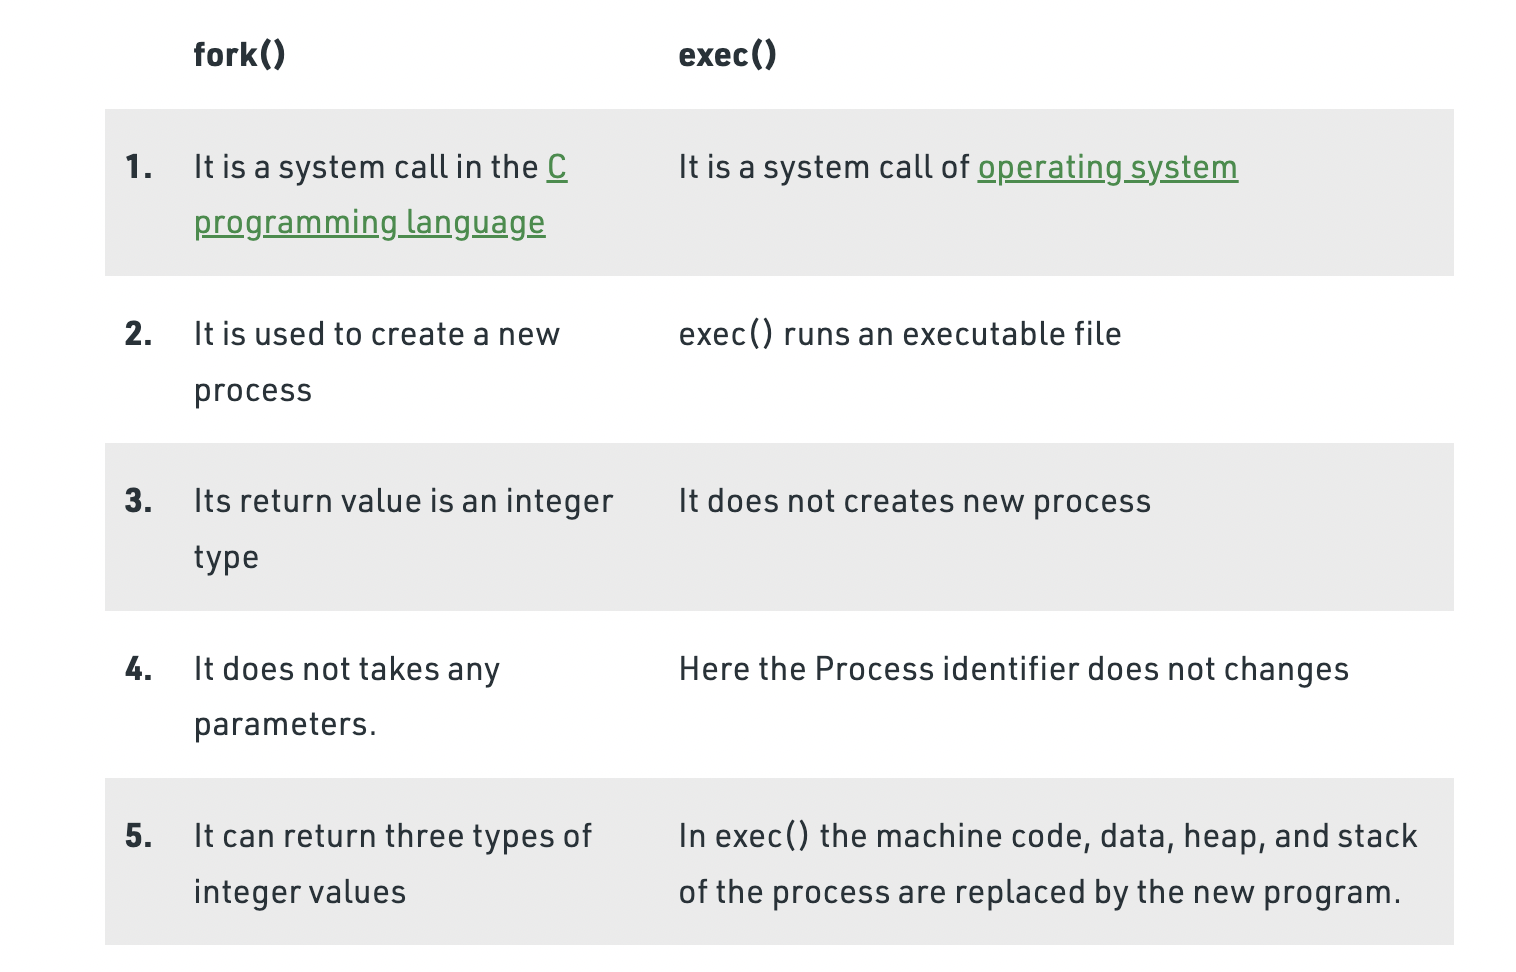

2. Ejemplo que muestra el uso de fork() en combinación con la función pipe()

In [20]:
%%writefile eje2.c

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <sys/types.h>
#include <sys/wait.h>
#include <unistd.h>

int main()
{
	
  //usaremos 2 pipes, el primero para enviar la entrada de string al padre, y el segundo para concatenar el string desde el hijo
	int fd1[2];
	int fd2[2]; 

	char fixed_str[] = " , bienvenido a la UOH";
	char input_str[100];
	pid_t p;

	if (pipe(fd1) == -1) {
		fprintf(stderr, "Pipe 1 falló");
		return 1;
	}
	if (pipe(fd2) == -1) {
		fprintf(stderr, "Pipe 2 falló");
		return 1;
	}
  printf("Ingrese su nombre:");
	scanf("%s", input_str);
	p = fork();

	if (p < 0) {
		fprintf(stderr, "fork falló");
		return 1;
	}

	// Proceso padre
	else if (p > 0) {
		char concat_str[100];

		close(fd1[0]); // Cerramos el modo de lectura del pipe 1


    //escribimos el string del pipe 1 y cerramos
		write(fd1[1], input_str, strlen(input_str) + 1);
		close(fd1[1]);

		// espera al hijo para enviar el string
		wait(NULL);

		close(fd2[1]); // Cerramos el modo escritura del pipe 2

    //lee el string enviado desde el hijo, lo imprime y concatena al mensaje final, luego cierra el pipe 2
		read(fd2[0], concat_str, 100);
		printf("Hola %s\n", concat_str);
		close(fd2[0]);
	}

	// Proceso hijo
	else {
		close(fd1[1]); // Cerramos el modo escritura del pipe 1 

    //Leemos el string del pipe 1
		char concat_str[100];
		read(fd1[0], concat_str, 100);

    //Concatemos el string
		int k = strlen(concat_str);
		int i;
		for (i = 0; i < strlen(fixed_str); i++)
			concat_str[k++] = fixed_str[i];

		concat_str[k] = '\0'; // string termina en '\0'

		// Cerramos ambos pipes
		close(fd1[0]);
		close(fd2[0]);

    //escribe el string concatenado y cierra el modo de escritura
		write(fd2[1], concat_str, strlen(concat_str) + 1);
		close(fd2[1]);

		exit(0);
	}
}


Overwriting eje2.c


In [21]:
!gcc eje2.c -o eje2

In [22]:
!./eje2

Ingrese su nombre:Carol
Hola Carol , bienvenido a la UOH
